In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Credit Scoring Classifier

This notebook demonstrates an end-to-end machine learning workflow for predicting credit default risk. 

The goal is to train a binary classification model that can assess whether a client is likely to default on a loan, using a labeled training dataset with financial and demographic features.

## Key Steps Covered:
- Data loading and exploration
- Preprocessing and feature engineering
- Model training and evaluation
- Generating predictions on test data
- Preparing a submission file in the required format



### About the Data
- id - identifier of the application
- <span style = 'color : red'> **flag** </span> - target (целевая переменная)
- pre_since_opened - days from credit opening date to data collection date
- pre_since_confirmed - days from credit information confirmation date till data collection date
- pre_pterm - planned number of days from credit opening date to closing date
- pre_fterm - actual number of days from credit opening date to closing date
- pre_till_pclose - planned number of days from data collection date until loan closing date
- pre_till_fclose - actual number of days from data collection date until loan closing date
- pre_loans_credit_limit - credit limit
- pre_loans_next_pay_summ - amount of the next loan payment
- pre_loans_outstanding - outstanding loan amount
- pre_loans_total_overdue - current overdue amount
- pre_loans_max_overdue_sum - maximum overdue amount
- pre_loans_credit_cost_rate - total cost of credit
- pre_loans5 - number of delinquencies of up to 5 days
- pre_loans530 - number of delinquencies from 5 to 30 days
- pre_loans3060 - number of delinquencies from 30 to 60 days
- pre_loans6090 - number of delinquencies from 60 to 90 days
- pre_loans90 - number of delinquencies of more than 90 days
- is_zero_loans_5 - flag: no delinquencies of up to 5 days
- is_zero_loans_530 - flag: no delinquencies of 5 to 30 days
- is_zero_loans_3060 - flag: no delinquencies of 30 to 60 days
- is_zero_loans_6090 - flag: no delinquencies of 60 to 90 days
- is_zero_loans90 - flag: no delinquencies of more than 90 days
- pre_util - ratio of outstanding loan amount to credit limit
- pre_over2limit - ratio of currently overdue debt to credit limit
- pre_maxover2limit - ratio of maximum overdue debt to credit limit
- is_zero_util - flag: ratio of outstanding loan amount to credit limit equals 0
- is_zero_over2limit - flag: ratio of current overdue debt to credit limit equals 0
- is_zero_maxover2limit - flag: ratio of maximum overdue debt to credit limit equals 0
- **<span style = 'color : blue'> enc_paym_{0…n} </span>** - monthly payment statuses of the last n months
- enc_loans_account_holder_type - type of relation to the loan
- enc_loans_credit_status - credit status
- enc_loans_account_cur - currency of the loan
- enc_loans_credit_type - credit type
- pclose_flag - flag: planned number of days from opening date to closing date of the loan
- fclose_flag - flag: actual number of days from credit opening date to closing date undefined

# Open files

In [6]:
# === Шаг 1: Загрузка данных ===
df_train = pd.read_parquet('./data/train.pq')
df_test = pd.read_parquet('./data/test.pq')

In [7]:
df_train

,id,flag,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,41794,0,3,9,16,9,15,14,16,3,...,3,3,3,4,1,3,4,1,0,0
1,160704,0,9,6,0,1,0,4,1,3,...,3,3,3,4,1,2,3,1,0,0
2,41771,0,12,16,14,8,10,11,10,2,...,3,3,3,4,1,2,3,1,0,1
3,160727,0,7,9,17,16,14,8,14,3,...,3,3,3,4,1,2,4,1,0,0
4,160729,0,9,9,4,8,1,11,10,3,...,3,3,3,4,1,2,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174995,139909,0,12,6,4,8,7,2,19,2,...,3,3,3,4,1,3,5,1,0,0
174996,10639,0,12,5,4,8,7,11,4,2,...,3,3,3,4,1,2,4,1,0,1
174997,4951,0,12,9,3,8,1,11,19,2,...,3,3,3,4,1,2,4,1,0,1
174998,77107,0,12,9,4,8,1,11,0,5,...,3,3,3,4,1,2,3,1,1,1


In [8]:
df_test

,id,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,225096,7,16,6,8,0,11,2,0,1,...,3,3,3,4,1,2,0,1,0,1
1,220040,7,10,17,8,8,11,10,2,3,...,3,3,3,4,1,2,3,1,0,1
2,26535,3,9,2,14,7,15,8,4,3,...,1,1,0,4,1,3,4,1,0,0
3,77272,7,9,2,10,8,8,16,4,2,...,3,3,3,4,1,2,4,1,0,0
4,193584,19,5,7,8,1,11,6,1,4,...,3,3,3,4,1,2,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,199075,19,9,4,8,1,11,17,4,3,...,3,3,3,4,1,2,3,1,1,1
74996,244188,5,12,17,16,1,11,0,2,3,...,3,3,3,4,1,3,2,1,0,0
74997,40363,9,1,3,5,2,6,17,2,3,...,3,3,3,4,1,3,3,1,0,0
74998,217364,19,6,15,9,12,11,13,6,3,...,3,3,3,4,1,2,4,1,0,0


In [9]:
print("\nОбзор тренировочных данных ---")
print(f"Размер тренировочных данных: {df_train.shape}")
print(f"Размер тестовых данных: {df_test.shape}")
print(df_train.info())


Обзор тренировочных данных ---
Размер тренировочных данных: (175000, 61)
Размер тестовых данных: (75000, 60)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 61 columns):
 #   Column                         Non-Null Count   Dtype
---  ------                         --------------   -----
 0   id                             175000 non-null  int64
 1   flag                           175000 non-null  int64
 2   pre_since_opened               175000 non-null  int64
 3   pre_since_confirmed            175000 non-null  int64
 4   pre_pterm                      175000 non-null  int64
 5   pre_fterm                      175000 non-null  int64
 6   pre_till_pclose                175000 non-null  int64
 7   pre_till_fclose                175000 non-null  int64
 8   pre_loans_credit_limit         175000 non-null  int64
 9   pre_loans_next_pay_summ        175000 non-null  int64
 10  pre_loans_outstanding          175000 non-null  int64
 11  pre_loa


Исследовательский анализ данных...


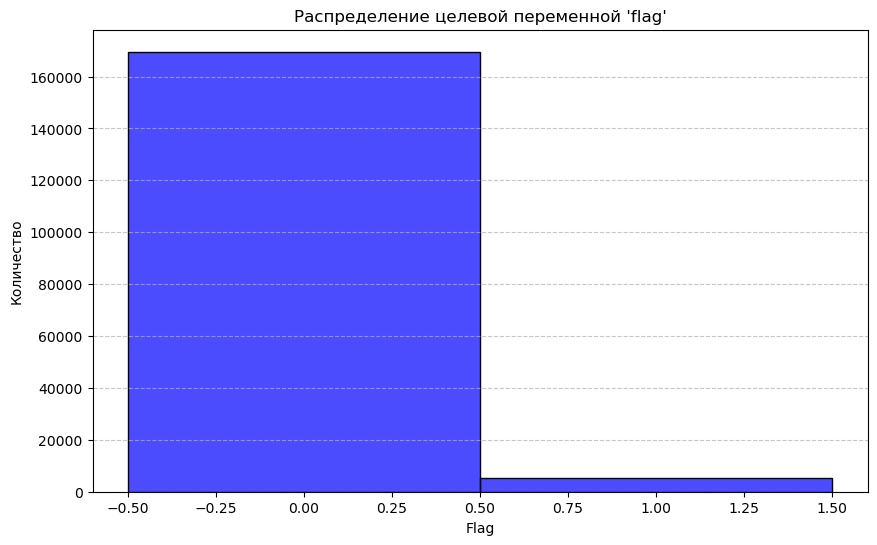

In [10]:
# === Шаг 2: Исследовательский анализ данных (EDA) ===
print("\nИсследовательский анализ данных...")

# 1. Визуализация распределения целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='flag', discrete=True, color='blue', alpha=0.7)
plt.title("Распределение целевой переменной 'flag'")
plt.xlabel("Flag")
plt.ylabel("Количество")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

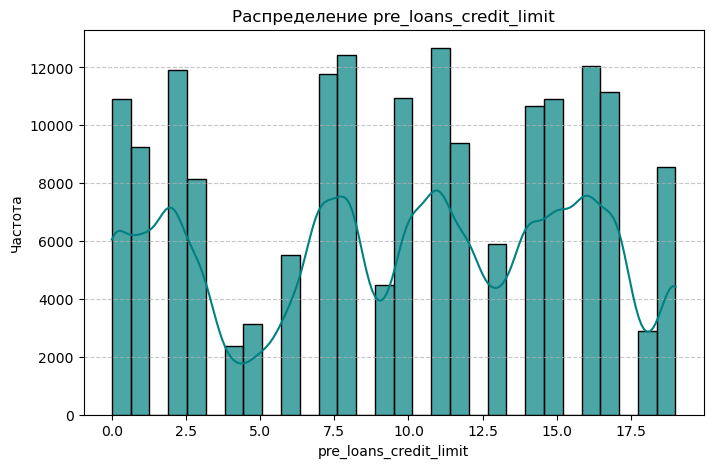

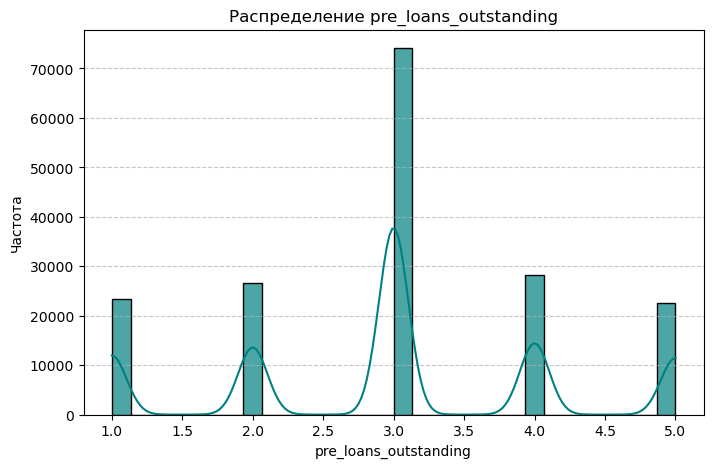

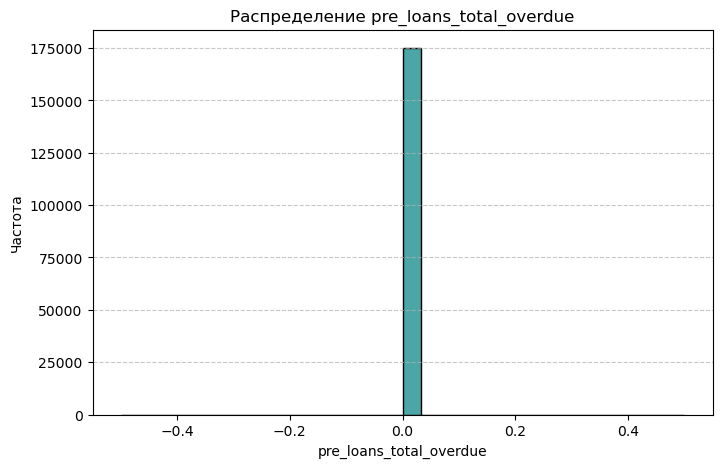

In [11]:
# 2. Распределение ключевых числовых признаков
numeric_columns = df_train.select_dtypes(include=['int64', 'float64']).columns
for col in ['pre_loans_credit_limit', 'pre_loans_outstanding', 'pre_loans_total_overdue']:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_train[col].dropna(), bins=30, kde=True, color='teal', alpha=0.7)
    plt.title(f"Распределение {col}")
    plt.xlabel(col)
    plt.ylabel("Частота")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


Анализ выбросов в числовых признаках...


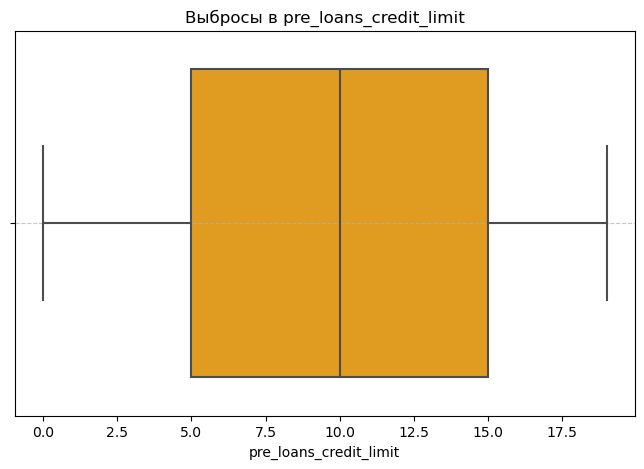

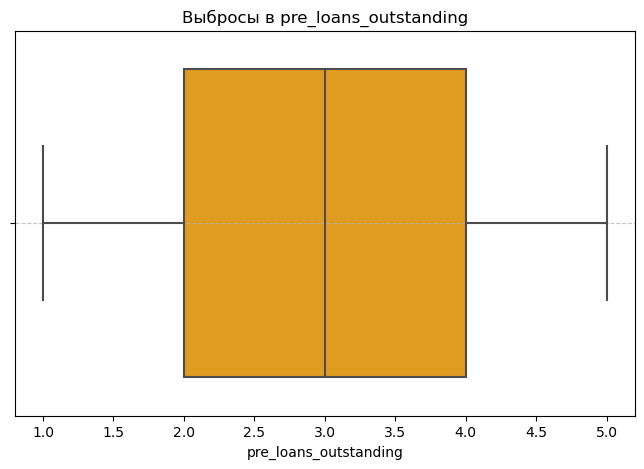

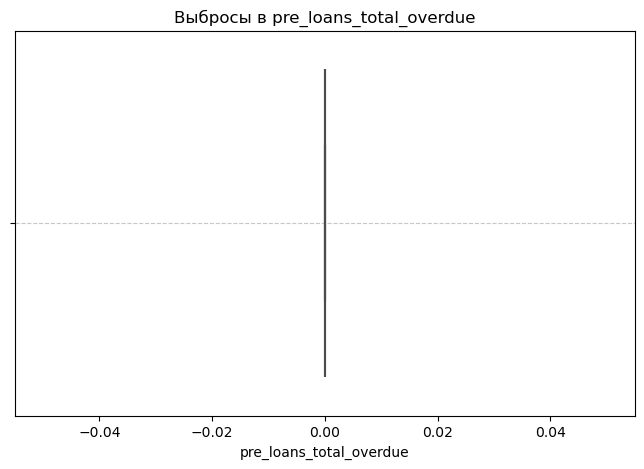

In [12]:
# 3. Анализ выбросов
print("\nАнализ выбросов в числовых признаках...")
for col in ['pre_loans_credit_limit', 'pre_loans_outstanding', 'pre_loans_total_overdue']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df_train[col], color='orange')
    plt.title(f"Выбросы в {col}")
    plt.xlabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

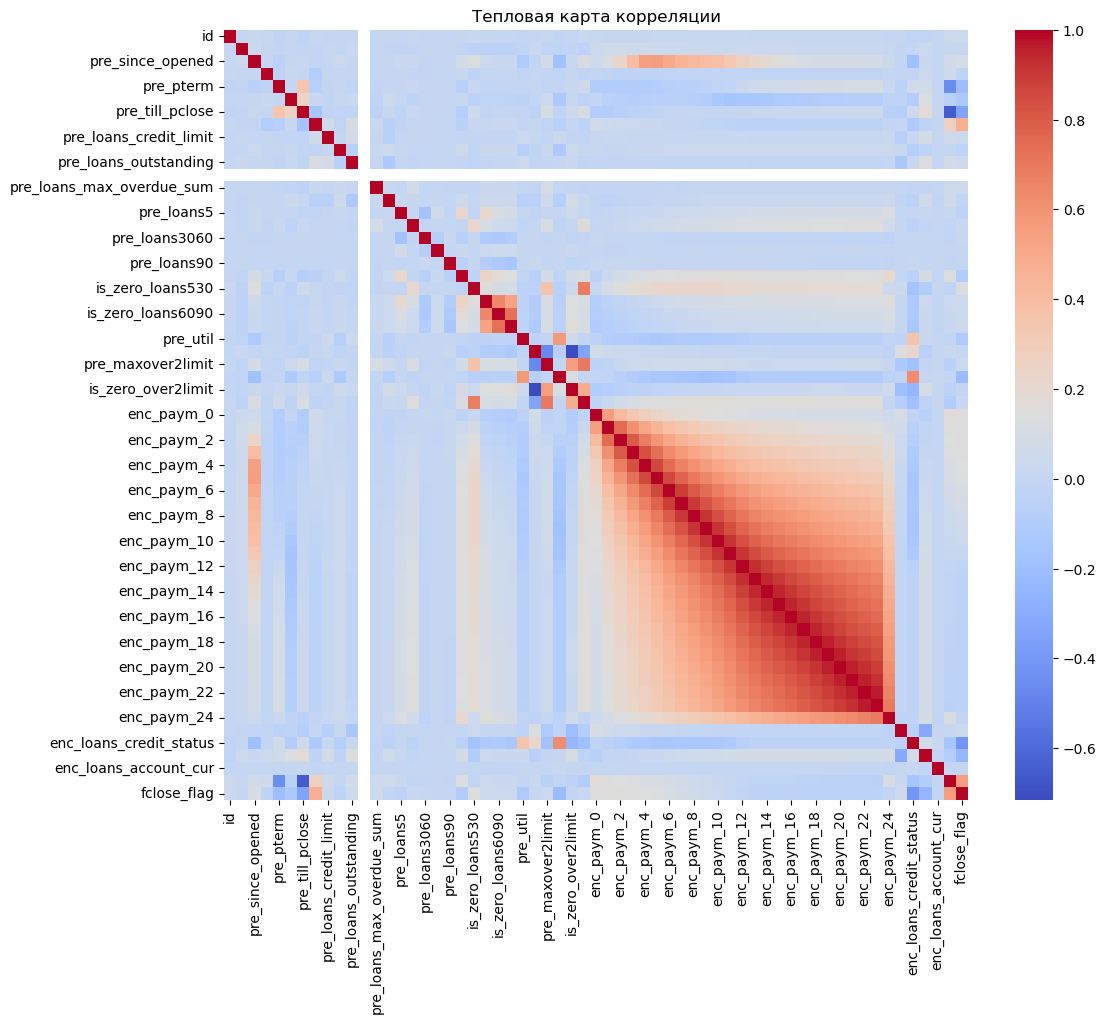

In [13]:
# 4. Тепловая карта корреляции
plt.figure(figsize=(12, 10))
correlation_matrix = df_train.corr()
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f", cbar=True)
plt.title("Тепловая карта корреляции")
plt.show()

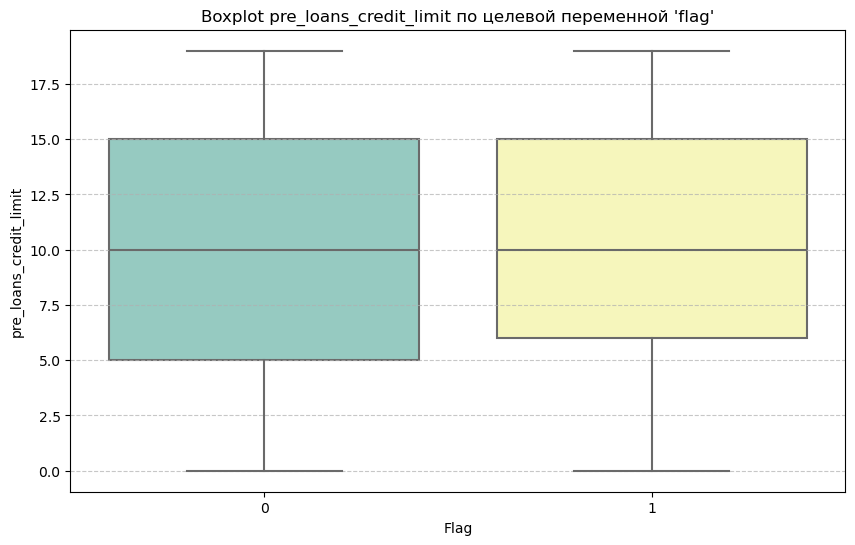

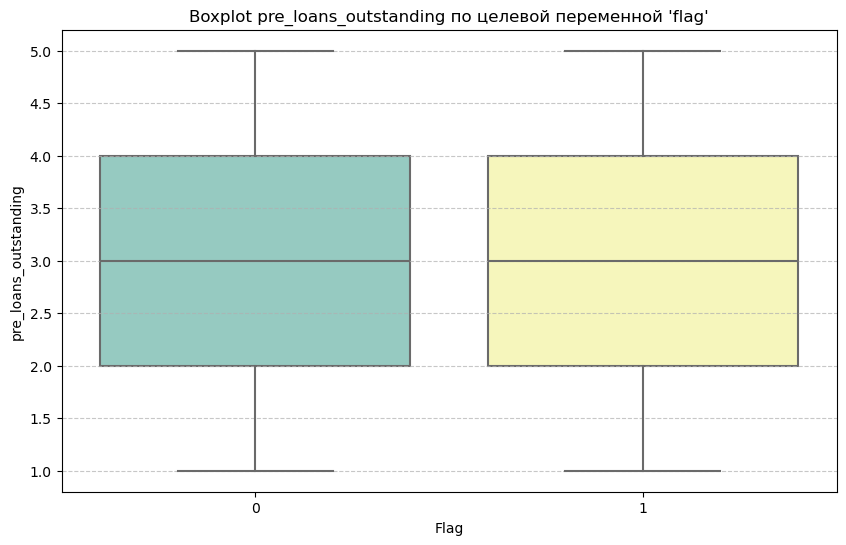

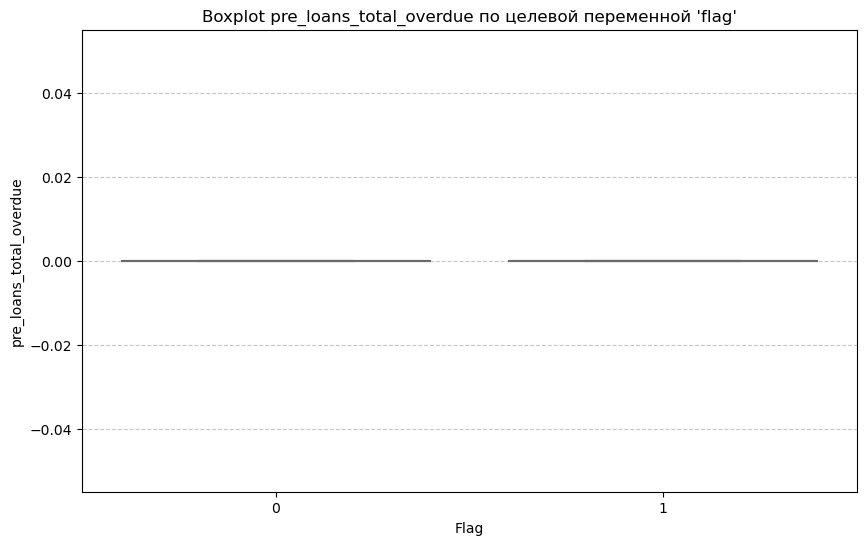

In [14]:
# 5. Boxplot для числовых признаков по целевой переменной
for col in ['pre_loans_credit_limit', 'pre_loans_outstanding', 'pre_loans_total_overdue']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_train, x='flag', y=col, palette='Set3')
    plt.title(f"Boxplot {col} по целевой переменной 'flag'")
    plt.xlabel("Flag")
    plt.ylabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [33]:
# 6. Анализ категориальных признаков
categorical_columns = df_train.select_dtypes(include=['object']).columns
if not categorical_columns.empty:
    for col in categorical_columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df_train, x=col, order=df_train[col].value_counts().index)
        plt.title(f"Распределение категориального признака {col}")
        plt.xlabel(col)
        plt.ylabel("Количество")
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
else:
    print("Нет категориальных признаков для анализа.")

Нет категориальных признаков для анализа.


In [16]:
# 7. Корреляции признаков с целевой переменной
target_corr = correlation_matrix['flag'].sort_values(ascending=False)
print("\nНаибольшая корреляция с целевой переменной 'flag':\n", target_corr.head(10))
print("\nНаименьшая корреляция с целевой переменной 'flag':\n", target_corr.tail(10))


Наибольшая корреляция с целевой переменной 'flag':
 flag          1.000000
enc_paym_1    0.058240
enc_paym_2    0.057118
enc_paym_3    0.054696
enc_paym_4    0.051555
enc_paym_5    0.047368
enc_paym_6    0.045844
enc_paym_7    0.042857
enc_paym_8    0.040645
enc_paym_9    0.037363
Name: flag, dtype: float64

Наименьшая корреляция с целевой переменной 'flag':
 is_zero_loans5            -0.019420
pre_util                  -0.027557
pre_maxover2limit         -0.027991
is_zero_util              -0.028196
is_zero_maxover2limit     -0.033863
is_zero_loans530          -0.040554
is_zero_loans90           -0.042736
is_zero_loans3060         -0.044835
is_zero_loans6090         -0.046163
pre_loans_total_overdue         NaN
Name: flag, dtype: float64


In [17]:
# === Шаг 3: Обработка пропущенных значений ===
numeric_columns = [col for col in df_train.select_dtypes(include=['int64', 'float64']).columns if col in df_test.columns]
categorical_columns = [col for col in df_train.select_dtypes(include=['object']).columns if col in df_test.columns]

# Заполнение числовых столбцов медианой
df_train[numeric_columns] = df_train[numeric_columns].fillna(df_train[numeric_columns].median())
df_test[numeric_columns] = df_test[numeric_columns].fillna(df_train[numeric_columns].median())

# Заполнение категориальных столбцов модой
for col in categorical_columns:
    df_train[col] = df_train[col].fillna(df_train[col].mode()[0])
    df_test[col] = df_test[col].fillna(df_train[col].mode()[0])

# Удаление дубликатов
print("\nУдаление дубликатов...")
df_train = df_train.drop_duplicates()


Удаление дубликатов...


In [18]:
# === Шаг 4: Кодирование категориальных переменных ===
for col in df_train.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

# Замена бесконечных значений
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
df_train.fillna(df_train.median(), inplace=True)
df_test.fillna(df_test.median(), inplace=True)

In [19]:
# === Шаг 5: Масштабирование числовых признаков ===
features = df_train.columns.drop(['id', 'flag'])
scaler = StandardScaler()
df_train[features] = scaler.fit_transform(df_train[features])
df_test[features] = scaler.transform(df_test[features])

In [20]:
# === Шаг 6: Разделение данных на тренировочные и валидационные ===
X = df_train.drop(columns=['id', 'flag'])
y = df_train['flag']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Обучение Random Forest с учетом веса классов...


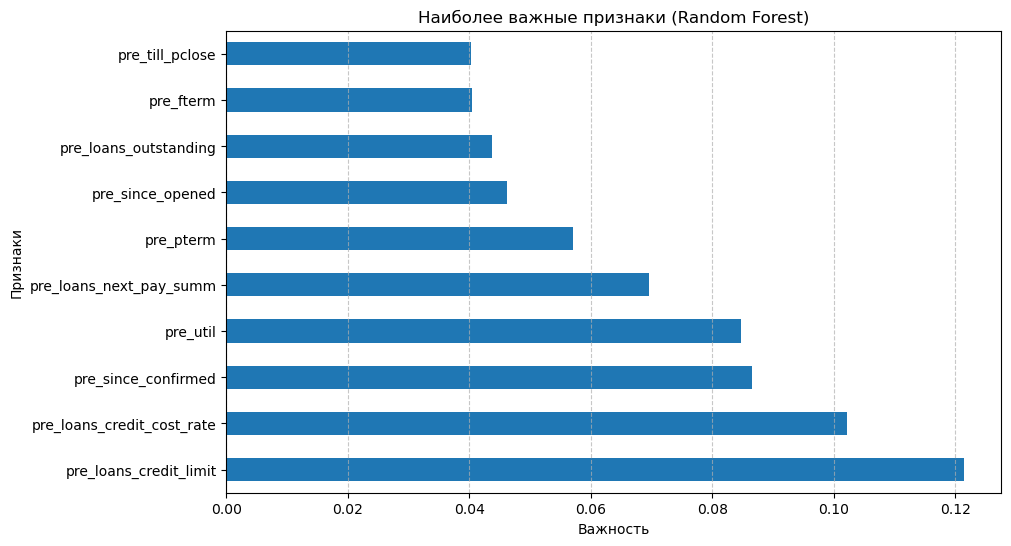

Random Forest - Precision: 0.0737, Recall: 0.0616, Accuracy: 0.9476, AUC-ROC: 0.6147


In [21]:
# === Шаг 7: Обучение Random Forest с учетом веса классов ===
print("\nОбучение Random Forest с учетом веса классов...")
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Важность признаков для Random Forest
feature_importances_rf = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances_rf.head(10).plot(kind='barh', title='Наиболее важные признаки (Random Forest)')
plt.xlabel("Важность")
plt.ylabel("Признаки")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Оценка Random Forest
y_pred_proba_rf = rf_model.predict_proba(X_val)[:, 1]
threshold_rf = 0.5  # Стандартный порог
y_pred_rf = (y_pred_proba_rf >= threshold_rf).astype(int)

precision_rf = precision_score(y_val, y_pred_rf)
recall_rf = recall_score(y_val, y_pred_rf)
accuracy_rf = accuracy_score(y_val, y_pred_rf)
auc_roc_rf = roc_auc_score(y_val, y_pred_proba_rf)

print(f"Random Forest - Precision: {precision_rf:.4f}, Recall: {recall_rf:.4f}, Accuracy: {accuracy_rf:.4f}, AUC-ROC: {auc_roc_rf:.4f}")


Обучение XGBoost...


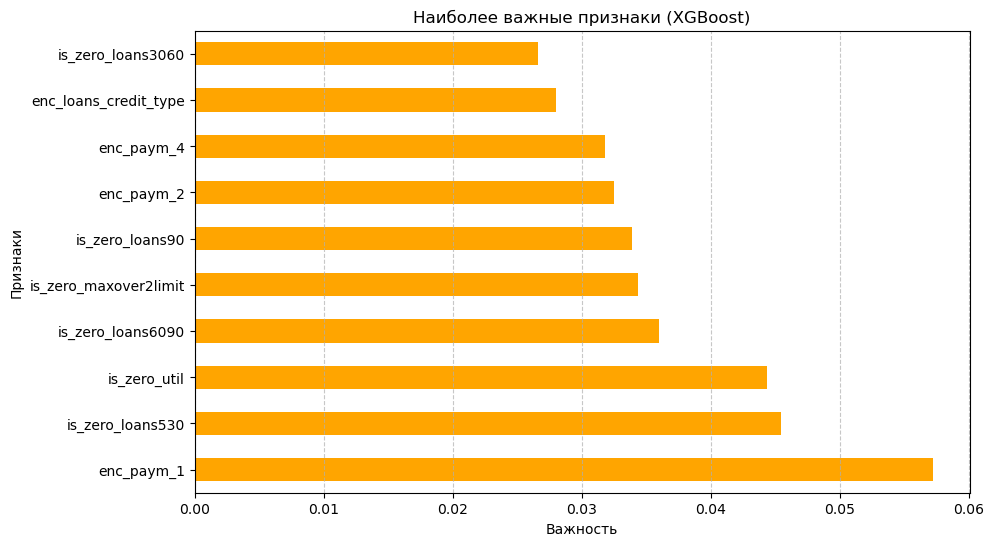

XGBoost - Precision: 0.1027, Recall: 0.1259, Accuracy: 0.9395, AUC-ROC: 0.6674


In [22]:
# === Шаг 8: Обучение модели XGBoost ===
print("\nОбучение XGBoost...")
xgb_model = XGBClassifier(scale_pos_weight=10, random_state=42)  # Настройка веса классов
xgb_model.fit(X_train, y_train)

# Важность признаков для XGBoost
feature_importances_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances_xgb.head(10).plot(kind='barh', title='Наиболее важные признаки (XGBoost)', color='orange')
plt.xlabel("Важность")
plt.ylabel("Признаки")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Оценка XGBoost
y_pred_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]
threshold_xgb = 0.5  # Стандартный порог
y_pred_xgb = (y_pred_proba_xgb >= threshold_xgb).astype(int)

precision_xgb = precision_score(y_val, y_pred_xgb)
recall_xgb = recall_score(y_val, y_pred_xgb)
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
auc_roc_xgb = roc_auc_score(y_val, y_pred_proba_xgb)

print(f"XGBoost - Precision: {precision_xgb:.4f}, Recall: {recall_xgb:.4f}, Accuracy: {accuracy_xgb:.4f}, AUC-ROC: {auc_roc_xgb:.4f}")

In [23]:
# === Шаг 9: Настройка порога для улучшения Recall ===
print("\nНастройка порога для XGBoost...")
threshold_xgb_adjusted = 0.3  # Снижение порога для улучшения Recall
y_pred_xgb_adjusted = (y_pred_proba_xgb >= threshold_xgb_adjusted).astype(int)

precision_xgb_adj = precision_score(y_val, y_pred_xgb_adjusted)
recall_xgb_adj = recall_score(y_val, y_pred_xgb_adjusted)
accuracy_xgb_adj = accuracy_score(y_val, y_pred_xgb_adjusted)
auc_roc_xgb_adj = roc_auc_score(y_val, y_pred_proba_xgb)

print(f"XGBoost (Сниженный порог) - Precision: {precision_xgb_adj:.4f}, Recall: {recall_xgb_adj:.4f}, Accuracy: {accuracy_xgb_adj:.4f}, AUC-ROC: {auc_roc_xgb_adj:.4f}")


Настройка порога для XGBoost...
XGBoost (Сниженный порог) - Precision: 0.0662, Recall: 0.3946, Accuracy: 0.8111, AUC-ROC: 0.6674


In [26]:
# === Шаг 10: Предсказание для тестовых данных ===
print("\nПредсказание для тестовых данных с использованием XGBoost...")
test_predictions = xgb_model.predict(df_test[features])
df_test['predictions'] = test_predictions
df_test[['id', 'predictions']].to_csv('data/credit_scoring_predictions.csv', index=False)

print("\nПредсказания сохранены в 'credit_scoring_predictions.csv'")


Предсказание для тестовых данных с использованием XGBoost...

Предсказания сохранены в 'credit_scoring_predictions.csv'


## Conclusion

In this project, a credit scoring model was built using a supervised machine learning approach.

Key outcomes:
- Cleaned and prepared real-world financial data in Parquet format
- Performed exploratory data analysis and handled missing values
- Trained and evaluated classification models (e.g., XGBoost, RandomForest)
- Generated predictions on an unlabeled test dataset
- Prepared a final submission in the correct format

This notebook demonstrates a full ML pipeline for classification tasks in the financial domain, and can serve as a foundation for further tuning and model deployment.
